#  Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication



## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [3]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 16, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads pre-trained word vectors trained on Wikipedia. (The vectors are created using an algorithm called GloVe.) To run the code, you'll need `gensim` package for that in your cpsc330 conda environment, which you can install as follows. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [19]:
import gensim
import gensim.downloader
import pandas as pd
print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# # This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the word vectors. 

**Your tasks:**

1. Calculate cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
# 1.Calculate cosine similarity for the following word pairs (word_pairs) using the similarity method of the model.

word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

for w1,w2 in word_pairs:
    similarity = glove_wiki_vectors.similarity(w1,w2)
    print("Similarity Between",w1,"and",w2 ,"is", round(similarity*100,2),"%")

Similarity Between coast and shore is 70.0 %
Similarity Between clothes and closet is 54.63 %
Similarity Between old and new is 64.32 %
Similarity Between smart and intelligent is 75.53 %
Similarity Between dog and cat is 87.98 %
Similarity Between tree and lawyer is 7.67 %


In [6]:
# 2.Do the similarities make sense?
# Ans:- Except between tree and lawyer there is similarity which make sence.

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 16 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class in these embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in them. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use them in your models. 

In [7]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [8]:
glove_wiki_vectors.most_similar("woman")

[('girl', 0.8472672700881958),
 ('man', 0.8323494791984558),
 ('mother', 0.827568769454956),
 ('boy', 0.7720510363578796),
 ('she', 0.7632068395614624),
 ('child', 0.7601761817932129),
 ('wife', 0.7505022883415222),
 ('her', 0.7445706129074097),
 ('herself', 0.7426273822784424),
 ('daughter', 0.7264456152915955)]

In [9]:
glove_wiki_vectors.most_similar( "illiterate")

[('uneducated', 0.8214871287345886),
 ('literate', 0.7737584114074707),
 ('ignorant', 0.653430700302124),
 ('destitute', 0.6307467818260193),
 ('malnourished', 0.6113425493240356),
 ('unemployed', 0.6080487370491028),
 ('underemployed', 0.6069870591163635),
 ('disenfranchised', 0.593757688999176),
 ('undernourished', 0.5847287178039551),
 ('undereducated', 0.5803024768829346)]

In [21]:
analogy("man", "businessman", "woman")

man : businessman :: woman : ?


,Analogy word,Score
0,businesswoman,0.774718
1,politician,0.679895
2,entrepreneur,0.663503
3,philanthropist,0.633681
4,socialite,0.610822
5,banker,0.608404
6,schoolteacher,0.607850
7,billionaire,0.587818
8,journalist,0.575222
9,industrialist,0.574385


In [ ]:
# MOdel is not stereotypical as per above examples and experiments.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's unlikely to be present in the vocabulary (e.g., the word "cpsc330"). 

In [22]:
# glove_wiki_vectors.word_vec("apple")
word = 'cpsc330'
if word in glove_wiki_vectors:
    print(True)
else:
    print(False)

False


<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

We will be using spaCy in this exercise. If you do not have spaCy in your course environment, here is how you can install it.  

```
> conda activate cpsc330
> conda install -c conda-forge spacy
```

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment. 
```
python -m spacy download en_core_web_md
```

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train logistic regression with bag-of-words features and show classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and show classification report on the test set. (You can find an example of extracting average embedding features using spaCy in [lecture 16](https://ubc-cs.github.io/cpsc330/lectures/16_natural-language-processing.html#sentiment-classification-using-average-embeddings).)  
3. Discuss your results. Which model is performing well. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 



In [3]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [4]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [5]:
sample_df.target.value_counts()

affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature              252 
exercise            217 
Name: target, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
x_train, y_train = train_df["moment"], train_df["target"]
x_test, y_test = test_df["moment"], test_df["target"]

In [10]:
# !python -m spacy download en_core_web_md
import spacy

nlp = spacy.load("en_core_web_md")

In [11]:
# 1.Train logistic regression with bag-of-words features and show classification report on the test set.
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pipe_lr = make_pipeline(
    CountVectorizer(stop_words='english'),
    LogisticRegression()
)
pipe_lr.fit(x_train,y_train)
pred = pipe_lr.predict(x_test)

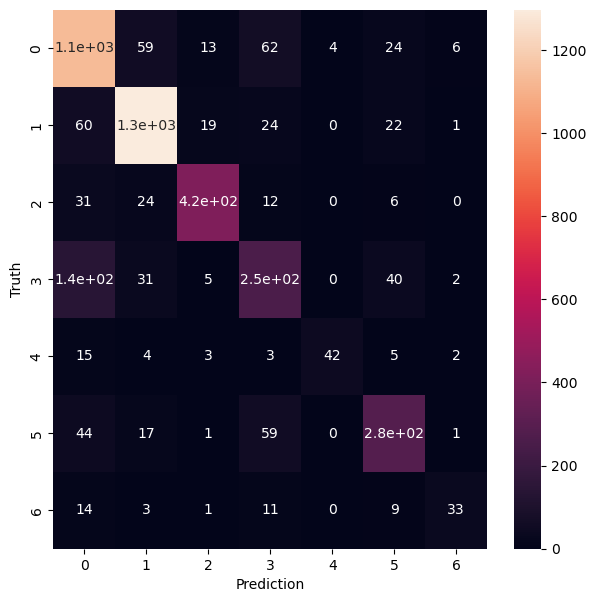

In [12]:
import warnings
warnings.filterwarnings('ignore')

cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [13]:
train_score = pipe_lr.score(x_train,y_train)
test_score = pipe_lr.score(x_test,y_test)
print(f"train_score:- {round(train_score,2)} Test_score:- {round(test_score,2)}")

train_score:- 0.96 Test_score:- 0.82


In [14]:
print(classification_report(y_test,pred))

                  precision    recall  f1-score   support

     achievement       0.79      0.87      0.83      1302
       affection       0.90      0.91      0.91      1423
         bonding       0.91      0.85      0.88       492
enjoy_the_moment       0.60      0.54      0.57       469
        exercise       0.91      0.57      0.70        74
         leisure       0.73      0.70      0.71       407
          nature       0.73      0.46      0.57        71

        accuracy                           0.82      4238
       macro avg       0.80      0.70      0.74      4238
    weighted avg       0.82      0.82      0.81      4238



In [16]:
# 2.Train logistic regression with average embedding representation extracted using spaCy and show classification report on the test set. 
#   (You can find an example of extracting average embedding features using spaCy in lecture 16.)
t = " ".join(x_train.values)
doc = nlp(t)

text_vectors = []
for token in doc.sents:
    vector = token.vector
    text_vectors.append(vector)

In [ ]:
# len(text_vectors)

In [17]:
def convert_into_vectors(data):
    
#     creating lemma of each word with respect to exampple
    lemma_text = []
    for val in data.values:
        t_v = []
        doc = nlp(val)
        for token in doc:
            if not token.is_space and not token.is_punct and not token.is_stop:
                lemma = token.lemma_
                t_v.append(lemma)
        lemma_text.append(t_v)
        
#     creating avg vectors
    word_vectors = []
    for example in lemma_text:
        sts = " ".join(example)
        doc1 = nlp(sts)
        word_vectors.append(doc1.vector)
    vec_data = pd.DataFrame(data = word_vectors) 
    
    return vec_data

In [18]:
word_vectors = convert_into_vectors(x_train)

In [ ]:
# import numpy as np
# a1 = [['mit','rude'],['fun','ruin','over']]
# s = [" ".join(i) for i in a1]
# s = pd.DataFrame(s)
# s = np.array(s)
# s = s.squeeze()
# nlp(s)

In [19]:
vec_data = pd.DataFrame(data = word_vectors) 
vec_data

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.678189,-1.773316,-0.521766,1.266399,1.424171,0.422629,1.511545,2.027857,0.764597,-0.520895,...,1.670896,-0.158807,2.676328,1.764018,-1.024572,1.938911,-0.528626,-1.520899,-0.116036,0.789746
1,0.548814,-1.208584,-3.781960,-1.247120,2.936180,-1.102264,-0.481197,0.398262,-0.672052,-1.230742,...,0.900648,-0.711724,1.507840,1.330722,-2.922340,-1.351156,2.299710,1.578118,-2.781992,2.115349
2,-1.306293,-2.808040,2.457800,0.709070,2.515993,1.340950,1.500700,3.577200,-2.126967,-2.688367,...,0.422327,0.037933,-2.871866,-0.672923,-1.203667,0.647371,-0.375767,-1.268437,0.059977,1.133783
3,0.372275,-0.123021,-3.395260,-0.579552,0.886955,-0.179160,1.723817,3.050865,-1.873340,0.455855,...,0.083173,-0.966252,1.258716,0.038620,-0.730075,-1.321715,1.091073,0.496401,-1.883636,0.259295
4,-1.336838,-2.256996,-2.825380,-1.561240,4.614676,-0.534274,3.691292,4.481930,2.244540,-0.551520,...,0.319091,0.286346,-4.971840,0.590710,0.041100,-2.853522,2.353156,0.773652,-0.101300,0.620784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9882,-0.022133,1.285385,-2.552602,-3.129862,-0.128201,-0.089767,2.417917,0.044192,-0.770702,0.741018,...,4.524095,-2.385900,-2.304322,-0.775112,-2.256621,-0.938790,2.242450,4.202508,-3.905658,0.566043
9883,-1.040034,-1.471311,-1.445022,-1.703906,3.483879,-1.183185,1.430809,3.601722,-1.160011,-1.644562,...,-1.010884,-0.337741,-1.338450,-1.078164,-0.660211,0.564268,1.535311,-0.338796,-1.701520,0.483729
9884,0.733618,0.501828,-2.861040,1.251804,2.115100,-0.993725,0.620710,3.128675,-4.542150,0.377283,...,2.168550,0.641210,-4.055973,-2.334450,0.573000,-0.200109,-0.221300,-0.741950,0.669335,1.784910
9885,-1.222000,-0.226290,0.037940,0.013565,-0.655020,3.658600,5.111600,3.821100,-2.556400,-0.632380,...,3.602400,0.095557,-3.378000,-1.391500,-1.502100,-0.055758,1.676800,4.296700,0.508270,-1.493700


In [20]:
from sklearn.base import TransformerMixin
import pandas as pd

class ConvertIntoVectorsTransformer(TransformerMixin):
    def transform(self, X):
        # Creating lemma of each word with respect to example
        lemma_text = []
        for val in X.values:
            t_v = []
            doc = nlp(val)
            for token in doc:
                if not token.is_space and not token.is_punct and not token.is_stop:
                    lemma = token.lemma_
                    t_v.append(lemma)
            lemma_text.append(t_v)

        # Creating average vectors
        word_vectors = []
        for example in lemma_text:
            sts = " ".join(example)
            doc1 = nlp(sts)
            word_vectors.append(doc1.vector)
        vec_data = pd.DataFrame(data = word_vectors) 
        return vec_data
    
    def fit(self, X, y=None):
        return self

In [21]:
# from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import LogisticRegression

# Create the pipeline
avg_emb_lr = make_pipeline(ConvertIntoVectorsTransformer(), LogisticRegression())

# Fit the pipeline to your data
avg_emb_lr.fit(x_train, y_train)


Pipeline(steps=[('convertintovectorstransformer',
                 <__main__.ConvertIntoVectorsTransformer object at 0x00000228A55A3A90>),
                ('logisticregression', LogisticRegression())])

In [22]:
train_score_lr = avg_emb_lr.score(x_train,y_train)
test_score_lr = avg_emb_lr.score(x_test,y_test)
print(f"train_score:- {round(train_score_lr,3)*100} Test_score:- {round(test_score_lr,3)*100}")

train_score:- 84.5 Test_score:- 79.7


In [23]:
pred1 = avg_emb_lr.predict(x_test)

In [24]:
print(classification_report(y_test,pred1))

                  precision    recall  f1-score   support

     achievement       0.79      0.84      0.82      1302
       affection       0.86      0.90      0.88      1423
         bonding       0.86      0.82      0.83       492
enjoy_the_moment       0.58      0.49      0.53       469
        exercise       0.74      0.73      0.73        74
         leisure       0.74      0.67      0.70       407
          nature       0.71      0.65      0.68        71

        accuracy                           0.80      4238
       macro avg       0.75      0.73      0.74      4238
    weighted avg       0.79      0.80      0.79      4238



In [25]:
accuracy = {'Train_score':[train_score*100,train_score_lr*100],'Test_score':[test_score*100,test_score_lr*100]}
accuracy = pd.DataFrame(accuracy,index = ['normal_Lgr','Avg_Emb_Lgr'])
accuracy

,Train_score,Test_score
normal_Lgr,95.620512,81.736668
Avg_Emb_Lgr,84.525134,79.683813


In [ ]:
# 3. Discuss your results. Which model is performing well. Which model would be more interpretable?
# Ans:- As per the results Logisticregression model with spacy average embedding is performing well and it is more 
#       interpretable cause it is not overfitting on our data.

In [ ]:
# 4. Are you observing any benefits of transfer learning here? Briefly discuss.
# Ans:- Here, in our models the transfer learning works well if the problem is about classification on multiclass data beacuase 
#       we've simply done the preprocessing and then creating vector using average embedding (dense vector) which, ultimatly 
#       leads to the prevention of overfitting on dataset.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [4]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
df.shape

(18249, 13)

In [6]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [7]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.9+ MB


It looks like the data ranges from the start of 2015 to March 2018 (~3 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [9]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [10]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain is Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

In [11]:
# Ans :- By examining the dataset, you can observe that there are multiple rows corresponding to each location,
#        each with its own set of measurements for different dates. This indicates that separate measurements are available for
#        each categorical value of the "Location" feature. Similarly, each date in the dataset represents a separate set of measurements,
#        suggesting that separate measurements are available for each categorical value of the "Date" feature.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<br><br>

### 2.3
rubric={points:4}

In the Rain is Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 18, with some improvements.

In [12]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [13]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [14]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [15]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

In [16]:
train_df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico,2.39
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico,2.38
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico,2.36
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico,2.26


<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> Because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw5?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side project on machine learning in a "blog post" or report format. It's fine if you just write it here in this notebook. Alternatively, you can publish your blog post publicly and include a link here. (See exercise 4.3.) The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.


This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


<br><br>

### 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

<br><br>

## (optional, not for marks) 4.3

Publish your blog post from 4.1 publicly using a tool like Hugo, or somewhere like medium.com, and paste a link here. Be sure to pick a tool in which code and code output look reasonable. This link could be a useful line on your resume!

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

<br><br><br><br>

### Congratulations on finishing all homework assignments! :clap: :clap: 

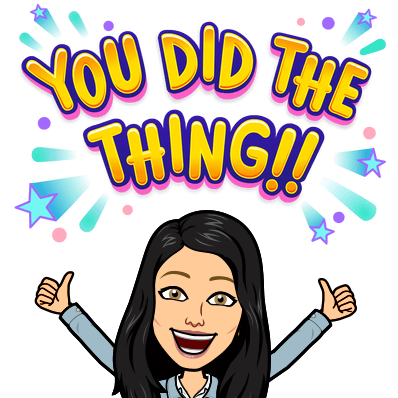

In [1]:
from IPython.display import Image

Image("eva-congrats.png")